In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.lines as lines
%matplotlib notebook

In [2]:
def chess_board(x,y, fields_in_row = 6):
    """ generate chessbord
    
    Args:
        x,y: position 0<=x,y<=1
        fields_in_row (int): number of chess field per row and column       

    Returns: 0 or 1 depending on whether the position in black or white
    """
    return (fields_in_row*x % 2 > 1) ^ (fields_in_row*y % 2 > 1)

In [3]:
def gen_batch(batch_size):
    """ creates new random batch """
    x = np.random.random([batch_size,2])
    y = [[1.*chess_board(*pos)] for pos in x]
    return x,y

<IPython.core.display.Javascript object>


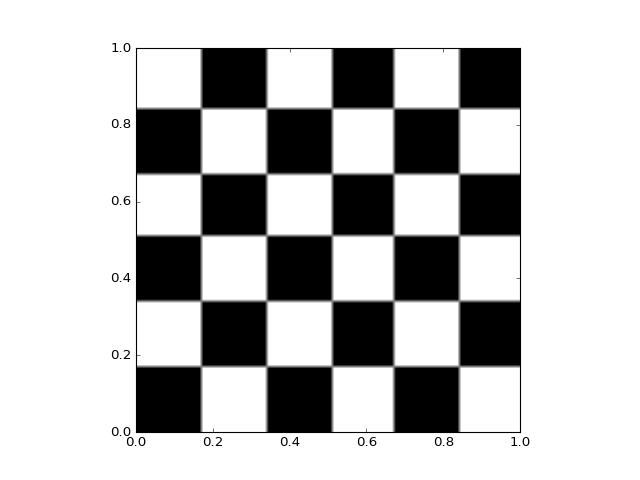

In [4]:
def draw_board_lattice():
    x_show = np.array(np.meshgrid(np.linspace(0,1,100,endpoint = False),np.linspace(0,1,100,endpoint = False))).reshape(2,-1).transpose()   
    y = np.array([chess_board(*x) for x in x_show]).reshape(100,100)
    plt.imshow(y,origin='lower',
        cmap=cm.gray, extent=(0, 1, 0, 1))
    
draw_board_lattice()
plt.show()

In [5]:
sess = tf.InteractiveSession()

In [6]:
input_ = tf.placeholder(tf.float32, shape=[None, 2])
target = tf.placeholder(tf.float32, shape=[None, 1])

In [7]:
N_h1 = 30
N_h2 = 30

W_h1 = tf.Variable(tf.truncated_normal([2,N_h1], stddev=0.1))
b_h1 = tf.Variable(tf.constant(0.1, shape=[N_h1]))
h1 = tf.nn.sigmoid(tf.matmul(input_, W_h1) + b_h1)

W_h2 = tf.Variable(tf.truncated_normal([N_h1,N_h2], stddev=0.1))
b_h2 = tf.Variable(tf.constant(0.1, shape=[N_h2]))
h2 = tf.nn.sigmoid(tf.matmul(h1, W_h2) + b_h2)

W_out = tf.Variable(tf.random_normal([N_h2,1]))
b_out = tf.Variable(tf.zeros([1]))
prediction = tf.nn.sigmoid(tf.matmul(h2, W_out) + b_out)

In [8]:
cross_entropy = tf.reduce_mean(-tf.reduce_sum(
    target * tf.log(prediction+10**-6) + 
    (1-target) * tf.log(1-prediction+10**-6), 
    reduction_indices=[1]))
correct_prediction = tf.equal(tf.greater(prediction, 0.5)[:,0],
                              tf.greater(target, 0.5)[:,0])
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

train_step = tf.train.AdamOptimizer(0.01).minimize(cross_entropy)
tf.initialize_all_variables().run()

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [9]:
def draw_board(x,y):
    plt.plot(x[y][:,0],x[y][:,1],'r.')
    plt.plot(x[y==False][:,0],x[y==False][:,1],'g.')
    
def show_prediction(length):
    x_test = np.random.random([length,2])
    tmp = sess.run(y, {x: x_test})
    classification = np.array([t[0] > 0.5 for t in tmp])
    draw_board(x_test, classification)
    plt.show()

In [10]:
epoch_num = 10**5
batch_size = 80
logging_loss = []
logging_accuracy = []
logging_epoch = []

class Plot:
    def __init__(self):
        self.fig, axes = plt.subplots(1,2)
    
        ax_logging = axes[0]
        ax_logging.set_xlabel('epoch')
        ax_logging.set_ylabel('accuracy')
        ax_logging.set_xlim(0, epoch_num)
        ax_logging.set_ylim(0, 1)
        self.line_accuracy = lines.Line2D([], [], color = 'b')
        ax_logging.add_line(self.line_accuracy)
        
        ax_board = axes[1]
        ax_board.set_xlim(0, 1)
        ax_board.set_ylim(0, 1)
        self.img = plt.imshow(np.zeros((2,2)),origin='lower',
            cmap=cm.gray, extent=(0, 1, 0, 1))
        self.img.norm.vmin = 0
        self.img.norm.vmax = 1
        
        plt.show()
        
    def update(self, board, logging_epoch, logging_accuracy):
        self.img.set_data(board)
        self.line_accuracy.set_xdata(logging_epoch)
        self.line_accuracy.set_ydata(logging_accuracy)
        self.fig.canvas.draw()


<IPython.core.display.Javascript object>


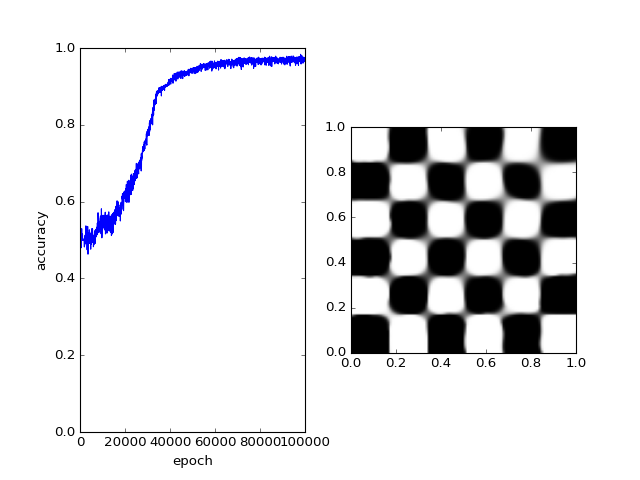

In [11]:
plot = Plot()

test_input = np.array(np.meshgrid(np.linspace(0,1,100,endpoint = False),np.linspace(0,1,100,endpoint = False))).reshape(2,-1).transpose() 
test_target = np.array([[chess_board(*point)] for point in test_input])
feed_test = {input_: test_input, 
             target: test_target}

for epoch in range(epoch_num):
    batch = gen_batch(batch_size)
    feed_train = {input_: batch[0], target: batch[1]}
    train_step.run(feed_dict = feed_train)
    
    if epoch%(epoch_num //2000) == 0:

        y_test, test_loss, test_accuracy = sess.run(
            [prediction, cross_entropy, accuracy], feed_dict = feed_test)  
        logging_loss.append(test_loss)
        logging_accuracy.append(test_accuracy)
        logging_epoch.append(epoch)    
        plot.update(y_test.reshape(100,100), logging_epoch, 
                    logging_accuracy)
        
        